In [21]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
# Financial News Data

# Load data
financial_news_data = pd.read_csv('data/IndianFinancialNews.csv')

# Reverse the order of rows
financial_news_data = financial_news_data[::-1]

# Parse data
# Covert the 'Date' column to a datetime object using the correct format (%b %d, %Y, %A )
financial_news_data['Parsed_Date'] = pd.to_datetime(financial_news_data['Date'], format='%B %d, %Y, %A', errors='coerce')

# Delete rows that are not necessary
condition = (financial_news_data['Parsed_Date'] >= '2019-05-16') & (financial_news_data['Parsed_Date'] <= '2020-05-26')
financial_news_data.drop(financial_news_data[condition].index, inplace=True) # In-place deletion

# Convert columns to strings
financial_news_data['Title'] = financial_news_data['Title'].astype(str)
financial_news_data['Description'] = financial_news_data['Description'].astype(str)

# Grouping data by date
financial_news_data = financial_news_data.groupby('Parsed_Date').agg({
    'Title': ' '.join,
    'Description': ' '.join
}).reset_index()

# The reset_index method is used to convert the grouped 'Date' from an index back into a column. 
# By default, the result of a groupby operation has the grouped column(s) as the index, 
# but we usually want it back as a regular column for further analysis or output.

# Sort by parsed date
financial_news_data = financial_news_data.sort_values(by='Parsed_Date')

#print(financial_news_data.tail())

In [23]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

financial_news_data['Clean_description'] = financial_news_data['Description'].apply(clean_text)
financial_news_data['Clean_title'] = financial_news_data['Title'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# WIPRO Stock Data

# Load data
stock_data_wipro = pd.read_csv('data/WIPRO_data.csv')

stock_data_wipro['Date'] = pd.to_datetime(stock_data_wipro['Date'], errors='coerce')

# Delete rows that are not necessary
condition = (stock_data_wipro['Date'] >= '2000-01-03') & (stock_data_wipro['Date'] <= '2003-02-09')
stock_data_wipro.drop(stock_data_wipro[condition].index, inplace=True) # In-place deletion

# Delete rows that have 'null' values
columns_to_check = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
stock_data_wipro.dropna(subset=columns_to_check, inplace=True)

#print(stock_data_wipro.head())
#print(stock_data_wipro.tail())

In [25]:
def z_score_normalization(X):
    mu = np.mean(X)  #Mean
    sigma = np.std(X)  #Standard Deviation
    X_norm = (X - mu) / sigma

    return(X_norm)

stock_data_wipro['open'] = z_score_normalization(stock_data_wipro['open'])
stock_data_wipro['high'] = z_score_normalization(stock_data_wipro['high'])
stock_data_wipro['low'] = z_score_normalization(stock_data_wipro['low'])
stock_data_wipro['close'] = z_score_normalization(stock_data_wipro['close'])
stock_data_wipro['adj_close'] = z_score_normalization(stock_data_wipro['adj_close'])
stock_data_wipro['volume'] = z_score_normalization(stock_data_wipro['volume'])

#print(stock_data_wipro.head())

In [26]:
# Merge data
merged_data = pd.merge(financial_news_data, stock_data_wipro, left_on='Parsed_Date', right_on='Date', how='inner')

# Drop the 'Date' column
merged_data.drop(columns=['Date'], inplace=True)

#print(merged_data.head())


In [27]:
# Lag features
merged_data['lag1'] = merged_data['close'].shift(1)
merged_data['lag2'] = merged_data['close'].shift(2)

# Drop rows with NaN values
merged_data.dropna(subset=['lag1', 'lag2'], inplace=True)

In [28]:
vectorizer = TfidfVectorizer() 
text_features = vectorizer.fit_transform(merged_data['Clean_title'] + ' ' + merged_data['Clean_description'])

In [29]:
# Splitting data into training set and test set

X = np.hstack((merged_data[['lag1', 'lag2']].values, text_features.toarray()))
Y = merged_data['close'].values

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(X, Y, np.arange(len(merged_data)), test_size=0.2, random_state=0)

#print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


In [30]:
# Function to evaluate model

def model_evaluation(model, X_test, Y_test, Y_pred):
    model_score = model.score(X_test, Y_test)

    mean_sq_err = mean_squared_error(Y_test, Y_pred)
    mean_abs_err = mean_absolute_error(Y_test, Y_pred)

    print(f'Accuracy: {model_score}')
    print(f'Mean Squared Error: {mean_sq_err}')
    print(f'Mean Absolute Error: {mean_abs_err}')

In [31]:
#  Function to plot Y_pred vs Y_test for comparison

def comparison_plot(merged_data, test_indices, Y_test, Y_pred):
    test_dates = merged_data['Parsed_Date'].iloc[test_indices]

    results = pd.DataFrame({
        'Date': test_dates,
        'Actual': Y_test,
        'Predicted': Y_pred
    }).sort_values('Date')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=results, x='Date', y='Actual', label='Actual Closing Price')
    sns.lineplot(data=results, x='Date', y='Predicted', label='Predicted Closing Price', linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted Closing Prices Over Time')
    plt.legend()

In [32]:
# Random Forest Regression

model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [33]:
# Evaluation of Random Forest Model

model_evaluation(model, X_test, Y_test, Y_pred)

Accuracy: 0.9758514576970424
Mean Squared Error: 0.024219160085702796
Mean Absolute Error: 0.10617420448863632


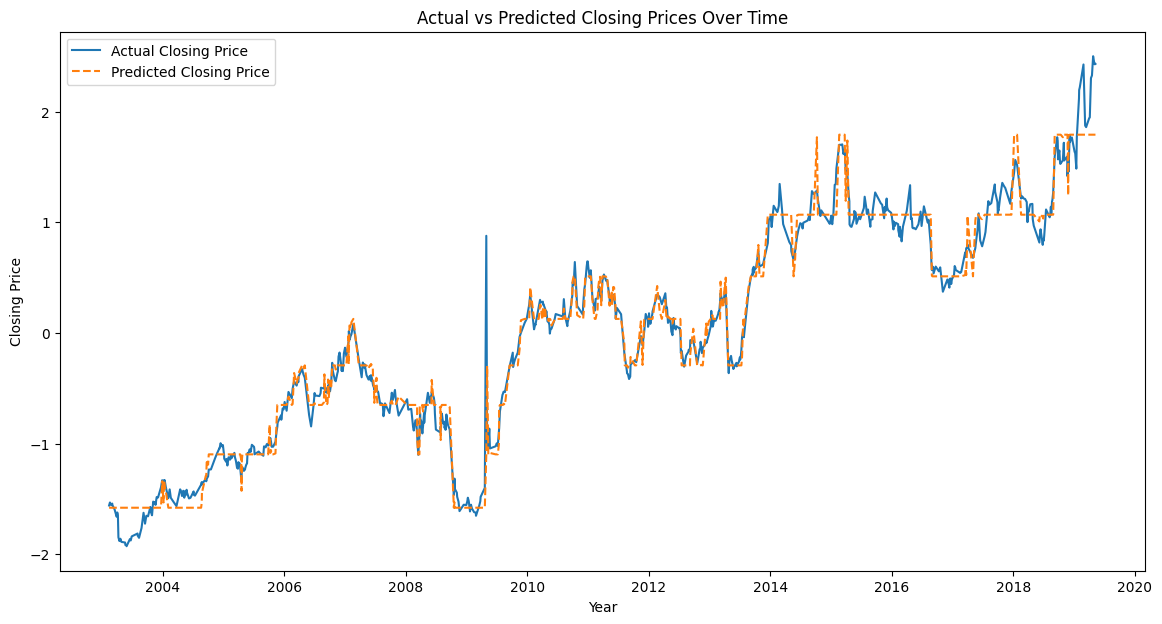

In [34]:
# Plot Y_pred vs Y_test for Random Forest Model

comparison_plot(merged_data, test_indices, Y_test, Y_pred)

In [35]:
# GBM (Gradient-Boosting Machines)

model = GradientBoostingRegressor(random_state=0)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [36]:
# Evaluation of GBM Model

model_evaluation(model, X_test, Y_test, Y_pred)

Accuracy: 0.9895619234685614
Mean Squared Error: 0.010468600685299666
Mean Absolute Error: 0.04170757828180515


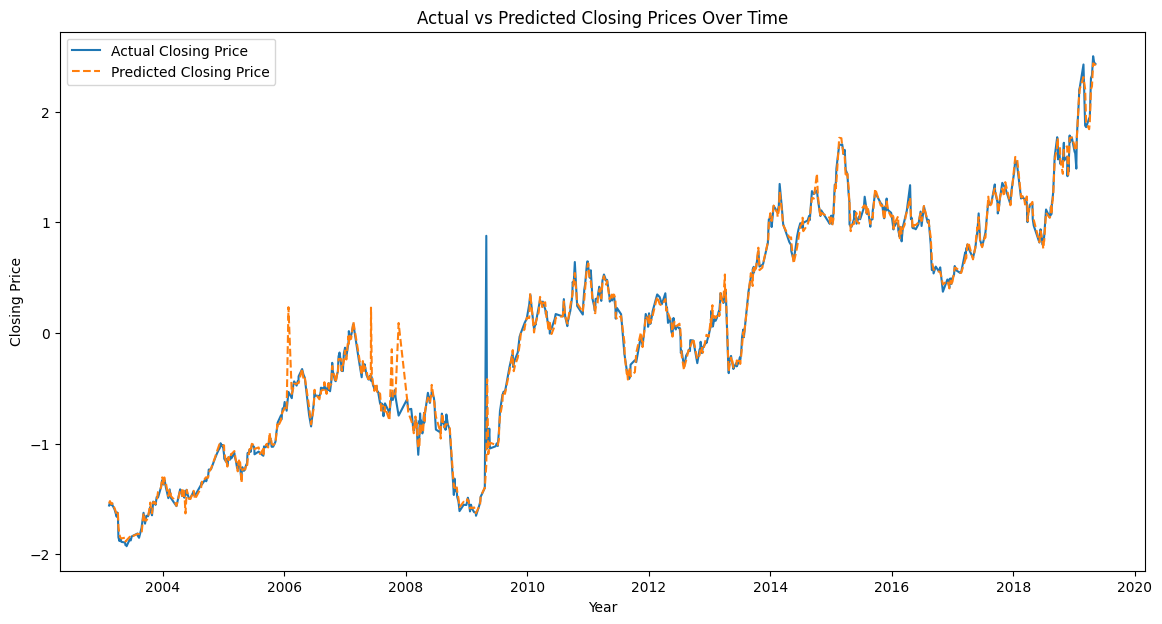

In [37]:
# Plot Y_pred vs Y_test for GBM Model

comparison_plot(merged_data, test_indices, Y_test, Y_pred)

In [38]:
# SVM (Support Vector Machines)

model = SVR()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [39]:
# Evaluation of SVM Model

model_evaluation(model, X_test, Y_test, Y_pred)

Accuracy: 0.9891954359908259
Mean Squared Error: 0.010836159885408965
Mean Absolute Error: 0.04962362192778477


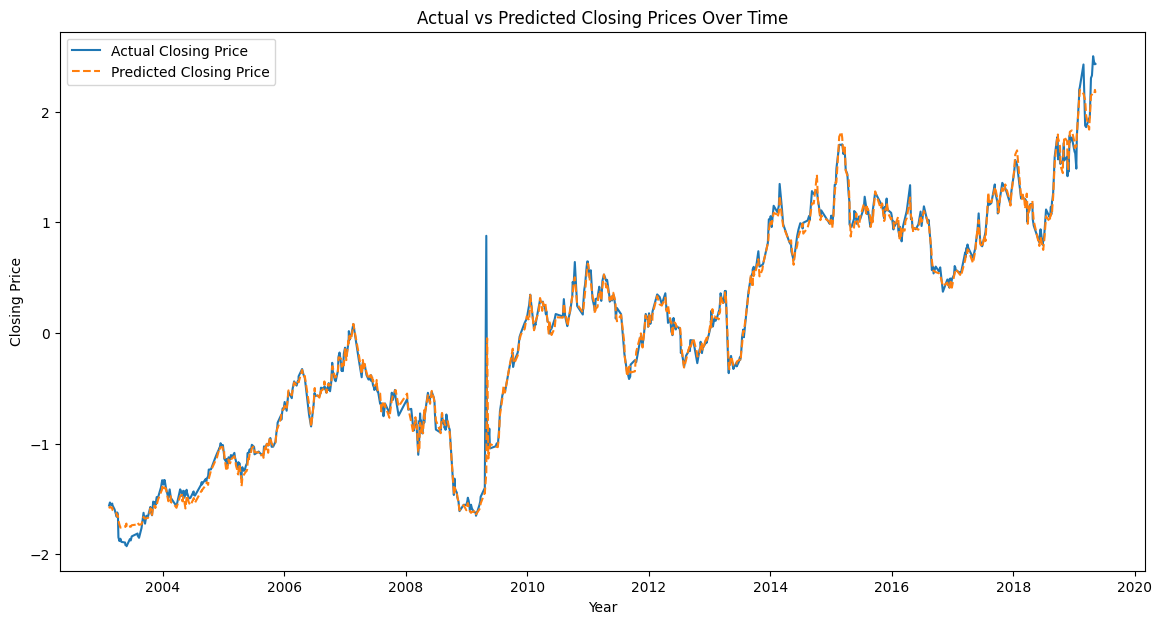

In [40]:
# Plot Y_pred vs Y_test for SVM Model

comparison_plot(merged_data, test_indices, Y_test, Y_pred)